In [ ]:
import pandas as pd

df = pd.read_excel('data.xlsx')

df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


Проводим классификацию для показателя CC50, который отражает токсичность соединений. Наша цель - определить, превышает ли CC50 медиану в выборке, чтобы быстро отбирать менее токсичные молекулы для разработки лекарств.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

df.rename(columns={'IC50, mM': 'IC50', 'CC50, mM': 'CC50'}, inplace=True)

# CC50 медиана
median_cc50 = df['CC50'].median()
df['CC50_above_median'] = (df['CC50'] > median_cc50).astype(int)

# баланс классов
class_counts = df['CC50_above_median'].value_counts()
print("Распределение классов:")
print(class_counts)

# Признаки
X = df.drop(columns=['IC50', 'CC50', 'SI', 'Unnamed: 0', 'CC50_above_median'])
y = df['CC50_above_median']

# Импутация
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


Распределение классов:
CC50_above_median
0    502
1    499
Name: count, dtype: int64


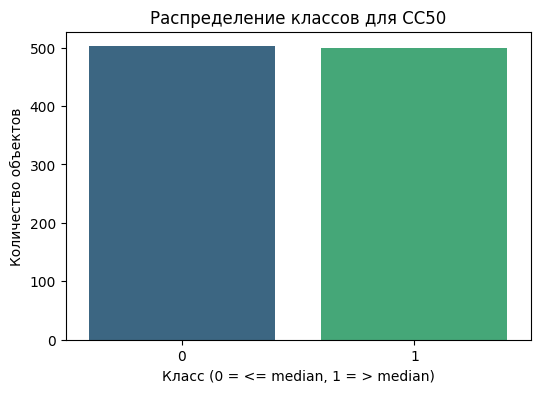

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xlabel('Класс (0 = <= median, 1 = > median)')
plt.ylabel('Количество объектов')
plt.title('Распределение классов для CC50')
plt.show()


Сбалансированные


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                        param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

print("Лучшие параметры XGBoost:", grid_xgb.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
models = {
    'Logistic Regression': y_pred_logreg,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'XGBoost (Best)': y_pred_best_xgb
}

for name, y_pred in models.items():
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"{name}:\n  Accuracy = {acc:.4f}\n  F1-score = {f1:.4f}\n  ROC-AUC = {auc:.4f}\n")


Logistic Regression:
  Accuracy = 0.7313
  F1-score = 0.7429
  ROC-AUC = 0.7316

Random Forest:
  Accuracy = 0.7164
  F1-score = 0.7299
  ROC-AUC = 0.7167

XGBoost:
  Accuracy = 0.7114
  F1-score = 0.7339
  ROC-AUC = 0.7119

XGBoost (Best):
  Accuracy = 0.6915
  F1-score = 0.7075
  ROC-AUC = 0.6918



[LightGBM] [Info] Number of positive: 399, number of negative: 401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18003
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498750 -> initscore=-0.005000
[LightGBM] [Info] Start training from score -0.005000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

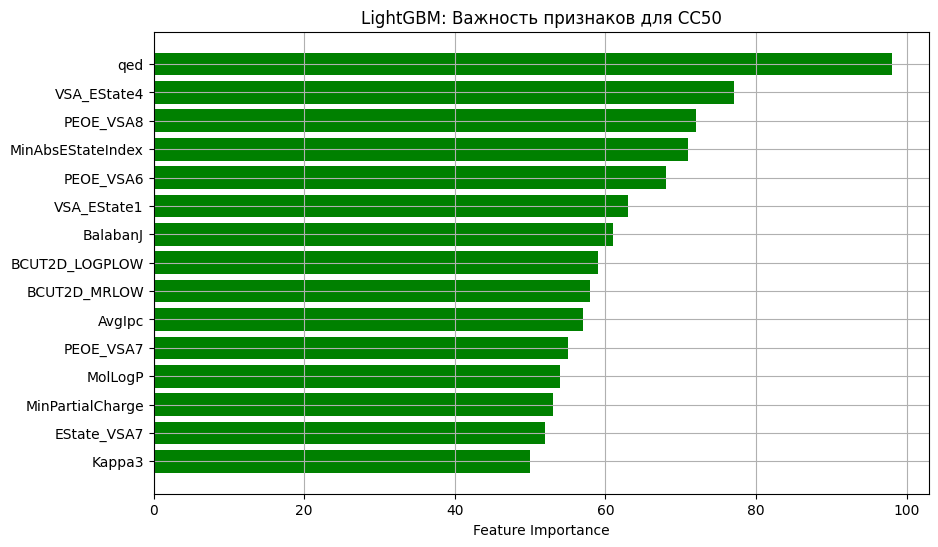

In [ ]:
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train, y_train)
importances = lgb_clf.feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[indices], importances[indices], color='green')
plt.xlabel('Feature Importance')
plt.title('LightGBM: Важность признаков для CC50')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


В задаче классификации токсичности (CC50) лучше всего справилась модель Logistic Regression: Accuracy = 0.7313, F1-score = 0.7429 и ROC-AUC = 0.7316. Это значит, что она хорошо определяет, превышает ли токсичность медианное значение.

Random Forest и XGBoost показали чуть ниже результаты, а XGBoost после настройки параметров (Best) даже немного ухудшил показатели. Это говорит о том, что в данной задаче простая модель Logistic Regression работает лучше, чем более сложные ансамбли.

qed - это показатель «drug-likeness», отражающий обобщённую пригодность молекулы для использования в фармацевтике. Чем выше qed, тем более «лекарственный» характер соединения. В нашем случае его высокая важность говорит о том, что лекарственные свойства напрямую связаны с токсичностью.
VSA_EState4, PEOE_VSA8, MinAbsEStateIndex - это дескрипторы, связанные с распределением электронной плотности и топологией молекулы. Они могут указывать на способность соединения взаимодействовать с клетками или белками, что напрямую влияет на токсичность.
PEOE_VSA6, VSA_EState1 - также отражают электронные и топологические свойства, подсказывая, что именно эти характеристики могут вызывать разрушение клеток.
BalabanJ - индекс топологической сложности, показывает, насколько запутанная или сложная молекула. Это может влиять на способность соединения проникать через клеточные мембраны и вызывать токсичность.
BCUT2D_LOGPLOW, BCUT2D_MRLOW - дескрипторы, связанные с липофильностью и молекулярной поляризуемостью. Они могут влиять на то, как молекула взаимодействует с мембранами и биомолекулами.
В целом, токсичность молекул в задаче CC50 сильно зависит от их электронной плотности, топологической сложности и «лекарственной» пригодности

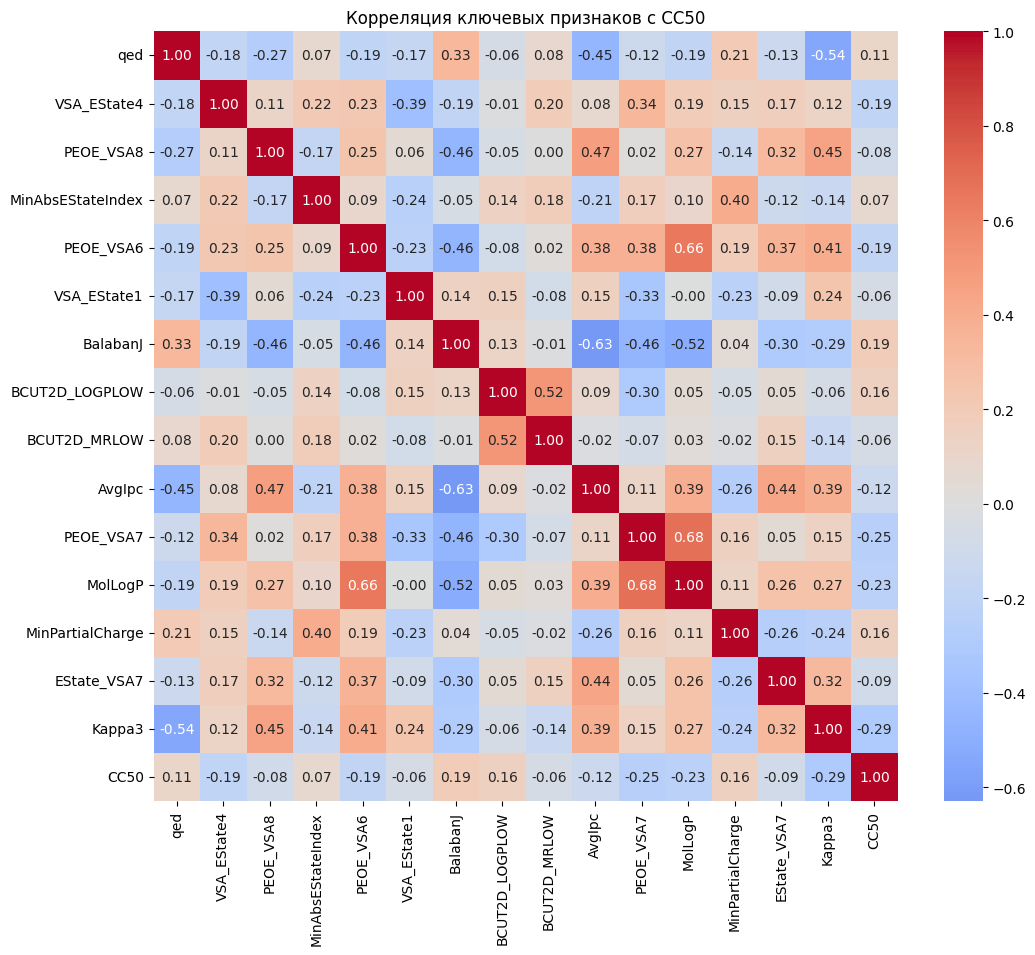

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# топ-15 признаков
top_features = np.array(X.columns)[indices[:15]]
corr_matrix = df[top_features.tolist() + ['CC50']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляция ключевых признаков с CC50')
plt.show()


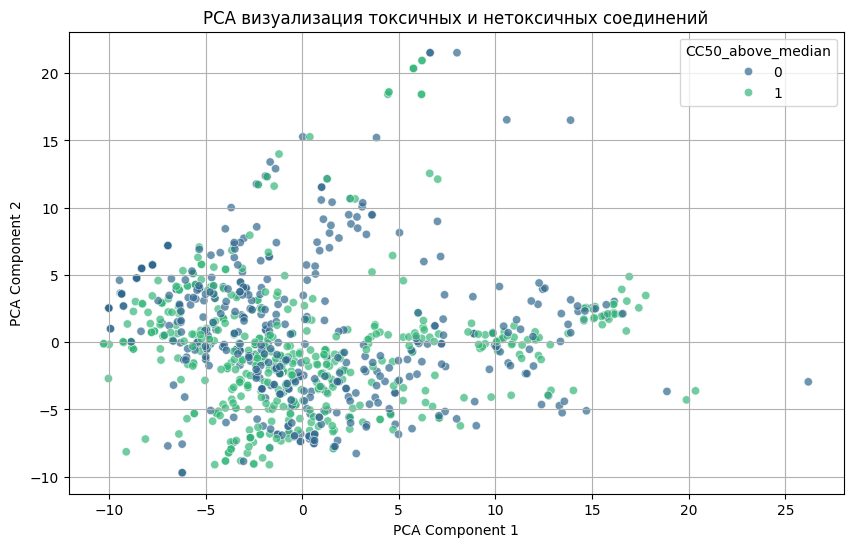

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['CC50_above_median'], palette='viridis', alpha=0.7)
plt.title('PCA визуализация токсичных и нетоксичных соединений')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='CC50_above_median')
plt.grid(True)
plt.show()


На графике PCA мы видим, как соединения распределились в двумерном пространстве на основе их признаков. Синие точки —-это соединения с низкой токсичностью (класс 0), зелёные  более токсичные (класс 1).

Видно, что классы пересекаются, то есть полностью разделить их по признакам довольно сложно. Тем не менее, есть области, где преобладает один из классов (например, в правой верхней части зелёных точек больше), что показывает, что модель всё-таки может улавливать закономерности и выделять токсичные молекулы.

Такой график помогает понять, как модель видит данные и где могут быть ошибки классификации.